## Nemoretriever Page Element v3 Demo

In [1]:
%load_ext autoreload
%autoreload 2

### Inference
- We provide the minimal steps to run the model.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from model import define_model
from utils import plot_sample, postprocess_preds_page_element, reformat_for_plotting

In [3]:
# Load image
path = "./example.png"
img = Image.open(path).convert("RGB")
img = np.array(img)

In [4]:
# Load model
model = define_model("page_element_v3")

 -> Loading weights from weights.pth


In [5]:
# Inference
with torch.inference_mode():
    x = model.preprocess(img)
    preds = model(x, img.shape)[0]

In [6]:
# Post-processing
boxes, labels, scores = postprocess_preds_page_element(preds, model.thresholds_per_class, model.labels)

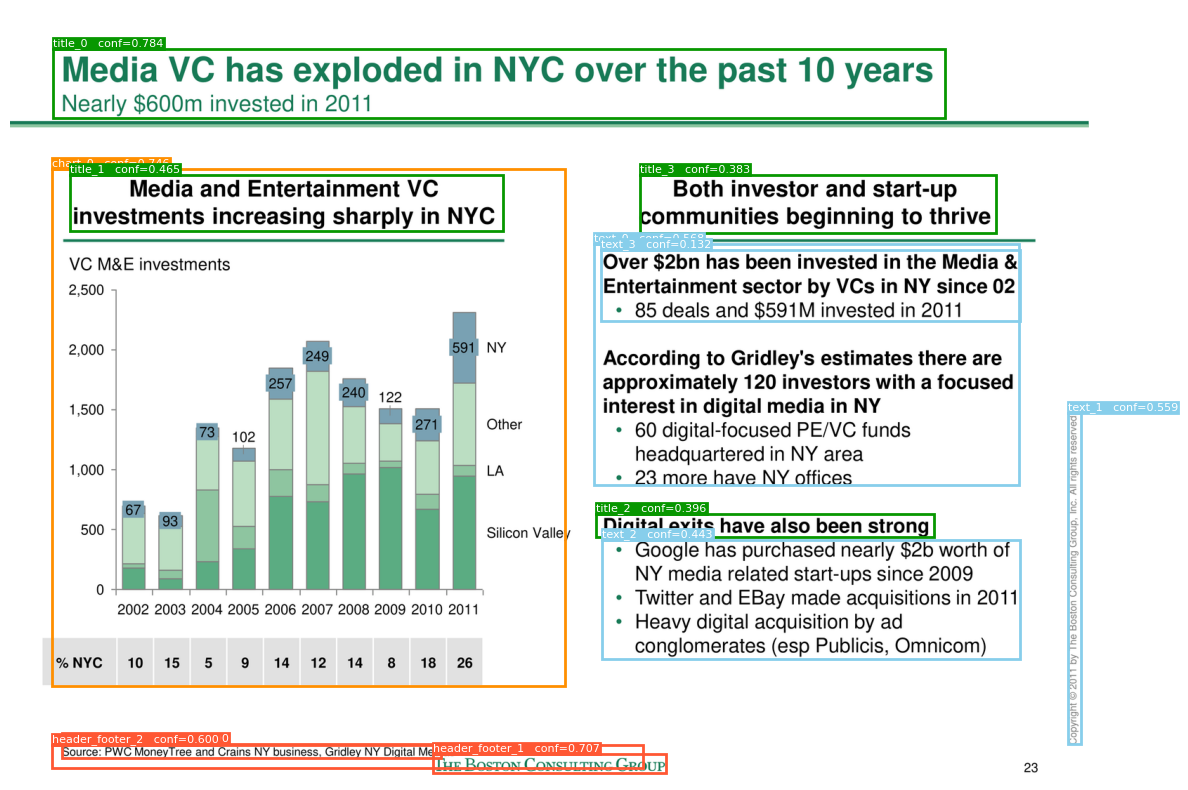

In [7]:
# Plot
boxes_plot, confs = reformat_for_plotting(boxes, labels, scores, img.shape, model.num_classes)

plt.figure(figsize=(15, 10))
plot_sample(img, boxes_plot, confs, labels=model.labels)
plt.show()

## Advanced Post-processing
- Predictions are a bit noisy as-is, we provide more utility functions for better ingestion
- Depending on your use-case, you might chose to apply some of the steps

In [8]:
from post_processing.wbf import weighted_boxes_fusion
from post_processing.page_elt_pp import expand_boxes, match_boxes_with_title
from post_processing.text_pp import postprocess_included

### Remove overlapping boxes using WBF
- Applied twice because once is not enough in some rare cases
- This ensure information is only indexed once per class

In [9]:
for _ in range(2):
    boxes, labels, scores = weighted_boxes_fusion(
        boxes[:, None],
        labels[:, None],
        scores[:, None],
        merge_type="biggest",
        conf_type="max",
        iou_thr=0.01,
    )

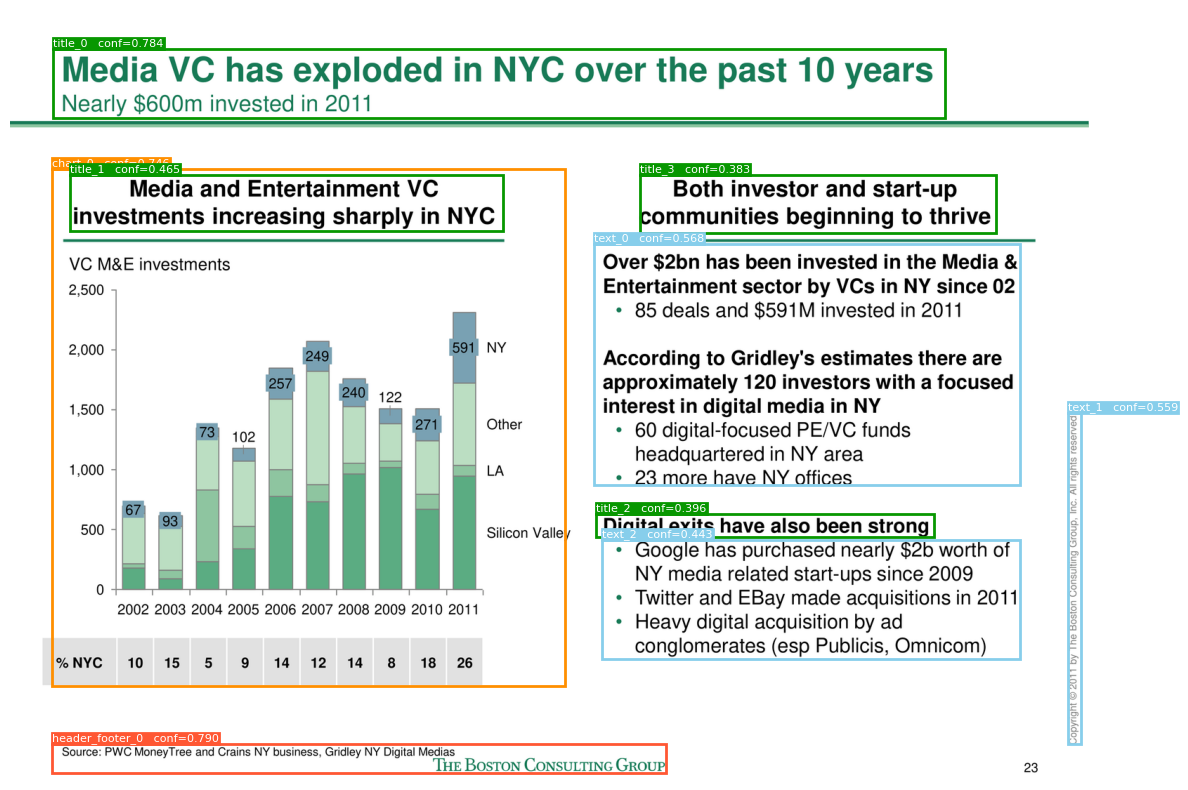

In [10]:
# Plot
boxes_plot, confs = reformat_for_plotting(boxes, labels, scores, img.shape, model.num_classes)

plt.figure(figsize=(15, 10))
plot_sample(img, boxes_plot, confs, labels=model.labels)
plt.show()

### Match with titles
- Although the model should detect titles, additional post-processing helps retrieve FNs
- Will expand boxes of classes `to_match_labels` to include nearby titles (if any)

In [11]:
# Reorder by y, x
order = np.argsort(boxes[:, 1] * 10 + boxes[:, 0])
boxes, labels, scores = boxes[order], labels[order], scores[order]

# Match with title
found_title = []
boxes, scores, labels, found_title = match_boxes_with_title(
    boxes,
    scores,
    labels,
    model.labels,
    to_match_labels=["chart", "table", "infographic"],
    remove_matched_titles=True,
    match_dist=0.05,
)

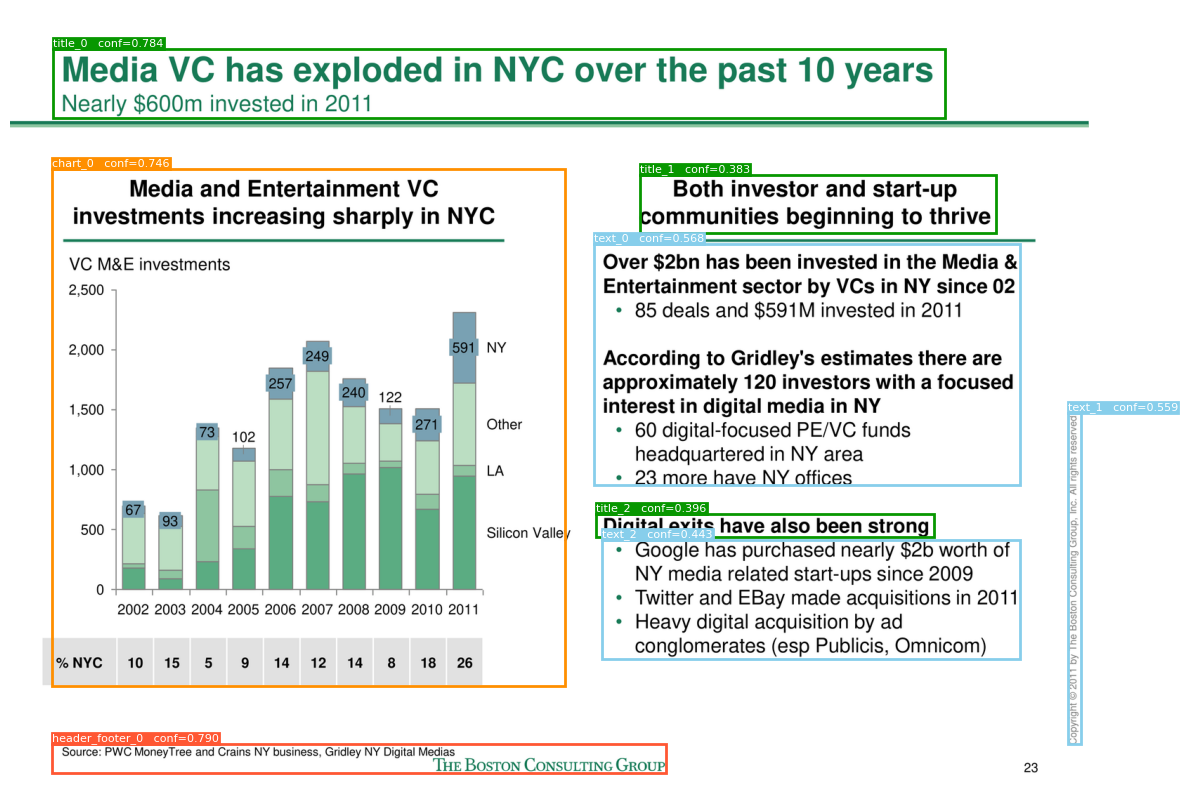

In [12]:
# Plot
boxes_plot, confs = reformat_for_plotting(boxes, labels, scores, img.shape, model.num_classes)

plt.figure(figsize=(15, 10))
plot_sample(img, boxes_plot, confs, labels=model.labels)
plt.show()

### Expansion
- This is mostly to retrieve titles, but this also helps when YOLOX boxes are too tight
- Different expansion for tables and charts 

In [13]:
ids_ = labels == model.labels.index("chart")
boxes[ids_] = expand_boxes(
    boxes[ids_],
    r_x=(1.025, 1.025),
    r_y=(1.05, 1.05),
    size_agnostic=False,
)

ids_ = labels == model.labels.index("table")
boxes[ids_] = expand_boxes(
    boxes[ids_],
    r_x=(1.01, 1.01),
    r_y=(1.05, 1.01),
)

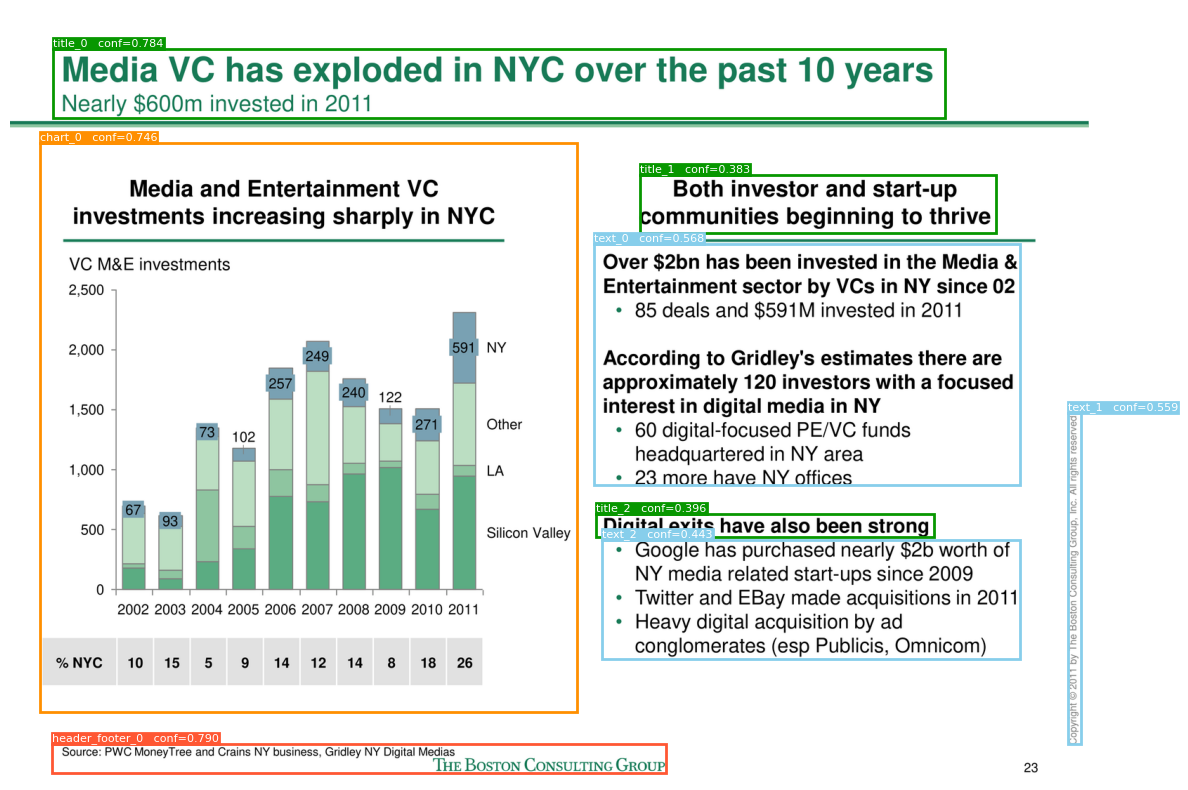

In [14]:
# Plot
boxes_plot, confs = reformat_for_plotting(boxes, labels, scores, img.shape, model.num_classes)

plt.figure(figsize=(15, 10))
plot_sample(img, boxes_plot, confs, labels=model.labels)
plt.show()

### Text inclusion PP
- Text already found in other boxes can be removed

In [15]:
for c in ["title", "text", "header_footer"]:
    boxes, labels, scores = postprocess_included(boxes, labels, scores, c, model.labels)

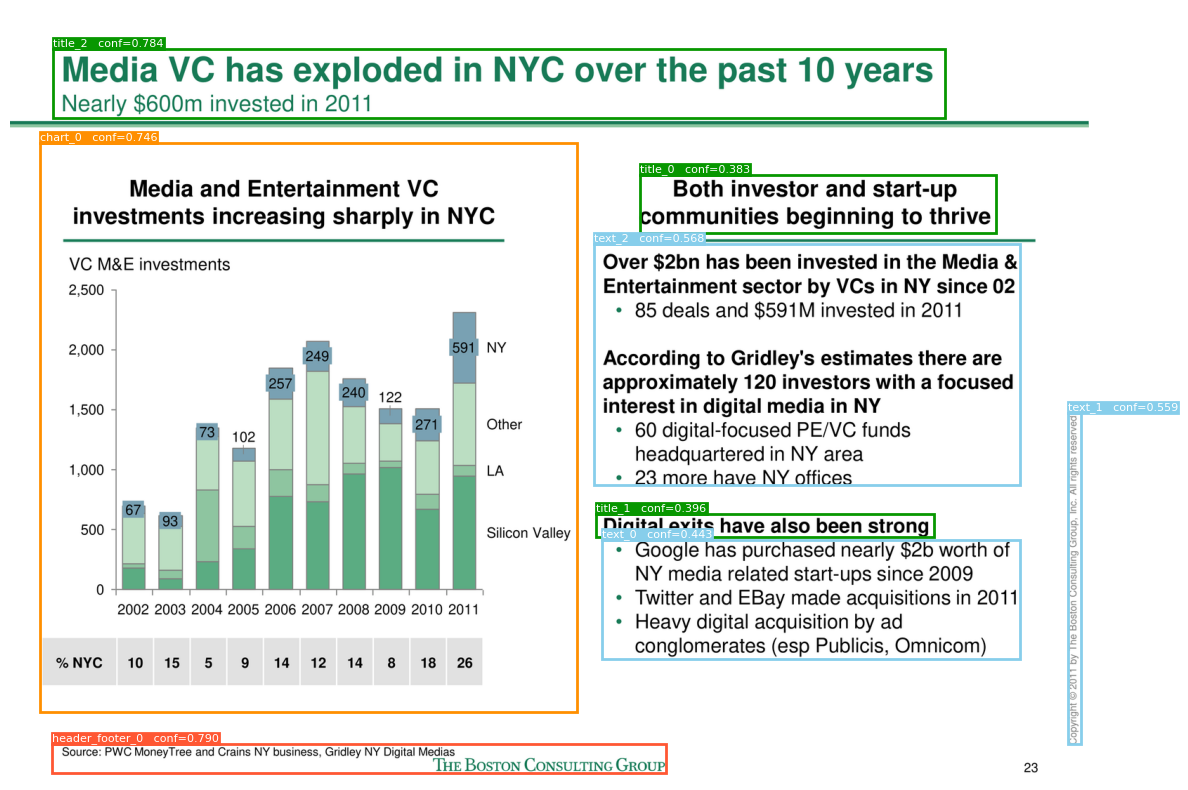

In [16]:
# Plot
boxes_plot, confs = reformat_for_plotting(boxes, labels, scores, img.shape, model.num_classes)

plt.figure(figsize=(15, 10))
plot_sample(img, boxes_plot, confs, labels=model.labels)
plt.show()

Done !